Implement a variant of the BLDTT for a spherical geometry

In [21]:
import numpy as np
import scipy as sp
import cartopy
import matplotlib.pyplot as plt
import math
import time
import matplotlib.tri as mtri
import seaborn as sns
import queue

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set(rc={"lines.linewidth": 2.5,"figure.figsize":(8,6)},font_scale=1.25)
sns.set_context("notebook")
sns.set_style("white")

rng = np.random.default_rng()

In [2]:
def cart2sph(x, y, z):
    r = np.sqrt(np.power(x, 2) + np.power(y, 2) + np.power(z, 2))
    colat = np.arctan2(np.sqrt(np.power(x, 2) + np.power(y, 2)), z)
    lon = np.arctan2(y, x)
    return r, colat, lon

In [3]:
def sph2cart(r, colat, lon):
    x = r * np.sin(colat) * np.cos(lon)
    y = r * np.sin(colat) * np.sin(lon)
    z = r * np.cos(colat)
    return x, y, z

In [4]:
def proj2sph(x, y, z, radius): # projects x y z to surface of sphere with radius 1
    return radius * np.array([x, y, z]) / np.linalg.norm(np.array([x, y, z]))

In [5]:
def sphtriarea(pA, pB, pC, radius):
    pA = proj2sph(*pA, 1)
    pB = proj2sph(*pB, 1)
    pC = proj2sph(*pC, 1)
    vBC = pB - pC
    a = np.arccos(1 - 0.5 * np.dot(vBC, vBC))
    vCA = pA - pC
    b = np.arccos(1 - 0.5 * np.dot(vCA, vCA))
    vAB = pA - pB
    c = np.arccos(1 - 0.5 * np.dot(vAB, vAB))
    s = (a + b + c) / 2
    z = np.tan(s / 2) * np.tan((s - a) / 2) * np.tan((s - b) / 2) * np.tan((s - c) / 2)
    S = 4 * np.power(radius, 2) * np.arctan(np.sqrt(z))
    return S

In [6]:
def latlon(x, y, z): # returns latitude and longitude in degrees 
    r, colat, lon = cart2sph(x, y, z)
    return np.rad2deg(lon + math.pi), np.rad2deg(math.pi / 2 - colat)

In [7]:
def barycords(p1, p2, p3, p):
    matrix = np.array([[p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]], [p1[2], p2[2], p3[2]]])
    alpha = sp.linalg.solve(matrix, p)
#     total = np.sum(np.abs(alpha))
    total = 1
    return alpha / total

In [8]:
def checkintri(p1, p2, p3, p):
# bary coord approach
    alpha = barycords(p1, p2, p3, p)
    if (alpha[0] >= 0) and (alpha[1] >= 0) and (alpha[2] >= 0):
        return True
    else:
        return False
# cross product method 
#     u = p2 - p1
#     v = p3 - p1
#     n = np.cross(u, v)
#     w = p - p1
#     gamma = np.dot(np.cross(u, w), n) / np.dot(n, n)
#     beta = np.dot(np.cross(w, v), n) / np.dot(n, n)
#     alpha = 1 - gamma - beta
#     if (0 <= alpha <= 1) and (0 <= beta <= 1) and (0 <= gamma <= 1):
#         return True
#     else:
#         return False
# determinant method 
#     det1 = np.linalg.det(np.array([p1, p2, p]))
#     det2 = np.linalg.det(np.array([p1, p, p3]))
#     det3 = np.linalg.det(np.array([p, p2, p3]))
#     if (det1 > 0) and (det2 > 0) and (det3 > 0):
#         return True
#     else:
#         return False

In [9]:
def circumpoly(a, b, c):
    return np.power(a, 2) + np.power(b, 2) - np.power(c, 2)

In [10]:
def trisides(v1, v2, v3):
    a = np.linalg.norm(v2 - v3)
    b = np.linalg.norm(v1 - v3)
    c = np.linalg.norm(v1 - v2)
    return a, b, c

In [11]:
def tricenter(v1, v2, v3, area):
#     center = (v1 + v2 + v3) / 3 # centroid
#     a = np.linalg.norm(v2 - v3) # circumcenter
#     b = np.linalg.norm(v1 - v3)
#     c = np.linalg.norm(v1 - v2)
    a, b, c = trisides(v1, v2, v3)
    center = (np.power(a, 2) * circumpoly(b, c, a) * v1 + np.power(b, 2) * circumpoly(c, a, b) * v2 + np.power(c, 2) * circumpoly(a, b, c) * v3) / (16 * np.power(area, 2))
    return center

In [12]:
def triradius(v1, v2, v3, center):
    r1 = np.linalg.norm(v1 - center)
    r2 = np.linalg.norm(v2 - center)
    r3 = np.linalg.norm(v3 - center)
    r = np.max([r1, r2, r3])
#     print(r)
    return r

In [13]:
def gcdist(p1, p2, radius):
    s = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
    theta = np.arccos(np.minimum(np.maximum(s, -1), 1))
    
    return radius * theta

In [14]:
def interpeval(alphas, s, t): # 1 s t st s^2 t^2
    return alphas[0] + alphas[1] * s + alphas[2] * t + alphas[3] * s * t + alphas[4] * np.power(s, 2) + alphas[5] * np.power(t, 2)

In [15]:
class Icosahedral_Mesh:  
    def __init__(self, subdivs, radius):
        Fz = 20     # base icosahedron has 20 faces, 30 edges, and 12 vertices
        Ez = 30
        Vz = 12
        self.levels = subdivs + 1 # number of levels
        self.subdivs = subdivs
        self.radius = radius # icosahedral mesh for sphere of radius R
        self.faces = Fz * np.power(4, subdivs) # each subdivision means 4x more faces
        self.triangles = [] # stores the triangles, each level of faces is in a different array
        self.initverts = 12
        
        phi = (1 + np.sqrt(5)) / 2
        initial_vertices = np.zeros((12, 3)) # x y z coordinates of the initial 12 vertices
        initial_vertices[0,:] = [0, 1, phi]
        initial_vertices[1,:] = [0, -1, phi]
        initial_vertices[2,:] = [0, 1, -phi]
        initial_vertices[3,:] = [0, -1, -phi]
        initial_vertices[4,:] = [1, phi, 0]
        initial_vertices[5,:] = [1, -phi, 0]
        initial_vertices[6,:] = [-1, phi, 0]
        initial_vertices[7,:] = [-1, -phi, 0]
        initial_vertices[8,:] = [phi, 0, 1]
        initial_vertices[9,:] = [phi, 0, -1]
        initial_vertices[10,:] = [-phi, 0, 1]
        initial_vertices[11,:] = [-phi, 0, -1]
        
        E = 7.5
        for i in range(self.levels): 
            self.triangles.append(np.empty((20 * np.power(4, i), 8))) # entries are [iv1, iv2, iv3, center_x, center_y, center_z, area, radius]
            E = 2 * E + 3 * 20 * np.power(4.0, i - 1)
            
        self.edges = int(E)
        self.vertexcount = 2 + self.edges - self.faces
        self.vertices = np.zeros((self.vertexcount, 3)) # stores the vertices of the triangles

        for i in range(12):
            x_cord, y_cord, z_cord = proj2sph(*initial_vertices[i,:], self.radius)
            self.vertices[i,:] = [x_cord, y_cord, z_cord]
            
        # now assign the initial triangles
        self.triangles[0][0,0:3] = [1, 2, 9]
        self.triangles[0][1,0:3] = [1, 2, 11]
        self.triangles[0][2,0:3] = [1, 5, 7]
        self.triangles[0][3,0:3] = [1, 5, 9]
        self.triangles[0][4,0:3] = [1, 7, 11]
        self.triangles[0][5,0:3] = [2, 6, 8]
        self.triangles[0][6,0:3] = [2, 6, 9]
        self.triangles[0][7,0:3] = [2, 8, 11]
        self.triangles[0][8,0:3] = [3, 4, 10]
        self.triangles[0][9,0:3] = [3, 4, 12]
        self.triangles[0][10,0:3] = [3, 5, 7]
        self.triangles[0][11,0:3] = [3, 5, 10]
        self.triangles[0][12,0:3] = [3, 7, 12]
        self.triangles[0][13,0:3] = [4, 6, 8]
        self.triangles[0][14,0:3] = [4, 6, 10]
        self.triangles[0][15,0:3] = [4, 8, 12]
        self.triangles[0][16,0:3] = [5, 9, 10]
        self.triangles[0][17,0:3] = [6, 9, 10]
        self.triangles[0][18,0:3] = [7, 11, 12]
        self.triangles[0][19,0:3] = [8, 11, 12]
        
        for i in range(Fz): # find the centers of the initial triangles and their areas
            self.triangles[0][i,0:3] = self.triangles[0][i,0:3] - 1
            iv1, iv2, iv3 = self.triangles[0][i,0:3]
            v1 = self.vertices[int(iv1),:]
            v2 = self.vertices[int(iv2),:]
            v3 = self.vertices[int(iv3),:]
            area = sphtriarea(v1, v2, v3, self.radius)
            self.triangles[0][i,6] = area
            center = tricenter(v1, v2, v3, area)
            self.triangles[0][i,3:6] = proj2sph(*center, self.radius)
            self.triangles[0][i,7] = triradius(v1, v2, v3, center)
            
        for i in range(self.subdivs): # perform the subdivisions
            for j in range(20 * np.power(4, i)): # iterate over the triangles in the previous level
                iv1 = self.triangles[i][j,0]
                iv2 = self.triangles[i][j,1]
                iv3 = self.triangles[i][j,2]
                v1 = self.vertices[int(iv1),:]
                v2 = self.vertices[int(iv2),:]
                v3 = self.vertices[int(iv3),:]
                t12 = (v1 + v2) / 2 # makes the new vertices at the midpoints of the edges of the old triangle
                v12 = proj2sph(*t12, self.radius)
                t13 = (v1 + v3) / 2
                v13 = proj2sph(*t13, self.radius)
                t23 = (v2 + v3) / 2
                v23 = proj2sph(*t23, self.radius)
                if (v12 == self.vertices).all(1).any():
                    iv12 = np.where((np.array(v12) == self.vertices).all(1))[0][0]
                else:
                    iv12 = self.initverts
                    self.vertices[self.initverts,:] = v12
                    self.initverts += 1
                if (v13 == self.vertices).all(1).any():
                    iv13 = np.where((np.array(v13) == self.vertices).all(1))[0][0]
                else:
                    iv13 = self.initverts
                    self.vertices[self.initverts,:] = v13
                    self.initverts += 1
                if (v23 == self.vertices).all(1).any():
                    iv23 = np.where((np.array(v23) == self.vertices).all(1))[0][0]
                else:
                    iv23 = self.initverts
                    self.vertices[self.initverts,:] = v23
                    self.initverts += 1
                area0 = sphtriarea(v1, v12, v13, self.radius)
                center0 = tricenter(v1, v12, v13, area0)
                area1 = sphtriarea(v3, v23, v13, self.radius)
                center1 = tricenter(v3, v23, v13, area1)
                area2 = sphtriarea(v2, v12, v23, self.radius)
                center2 = tricenter(v2, v12, v23, area2)
                area3 = sphtriarea(v12, v13, v23, self.radius)
                center3 = tricenter(v12, v13, v23, area3)
                self.triangles[i+1][4 * j] = [iv1, iv13, iv12, *proj2sph(*center0, self.radius), area0, triradius(v1, v12, v13, center0)]
                self.triangles[i+1][4 * j + 1] = [iv3, iv23, iv13, *proj2sph(*center1, self.radius), area1, triradius(v3, v23, v13, center1)]
                self.triangles[i+1][4 * j + 2] = [iv2, iv12, iv23, *proj2sph(*center2, self.radius), area2, triradius(v2, v12, v23, center2)]
                self.triangles[i+1][4 * j + 3] = [iv12, iv13, iv23, *proj2sph(*center3, self.radius), area3, triradius(v12, v13, v23, center3)]
                
#     def assign_points_lat_lon(points): # given lat lon of points, assign them to triangles at each level
         
    def assign_points_cart(self, points):
#         t0 = time.time()
        self.points = points # the array of point positions [x, y, z]
        self.pointcount = np.shape(points)[0] # the number of points
        self.pointlocs = [[[] for j in range(self.pointcount)] for i in range(self.levels)] # stores the triangle index each point is in
        self.tripoints = [] # stores the point indices each triangle contains
        for i in range(self.levels): # do this at each level
            self.tripoints.append([[] for i in range(20 * np.power(4, i))])
            for j in range(self.pointcount): # assign all the points
                if i > 0:
                    lbound = 4 * self.pointlocs[i-1][j][0]
                    rbound = lbound + 4
                else:
                    lbound = 0
                    rbound = 20
                for k in range(lbound, rbound): # iterate through the triangles to check if a point is in each one
                    p1 = self.vertices[int(self.triangles[i][k,0])]
                    p2 = self.vertices[int(self.triangles[i][k,1])]
                    p3 = self.vertices[int(self.triangles[i][k,2])]
                    if checkintri(p1, p2, p3, self.points[j]):
                        self.tripoints[i][k].append(j)
                        self.pointlocs[i][j].append(k)
                        break
#         t1 = time.time()
#         print(t1 - t0)
                        
    def assign_values(self, values):
        assert self.pointcount == np.shape(values)[0], "Values is the wrong size"
        self.values = values
    
    def assign_areas(self, areas):
        assert self.pointcount == np.shape(values)[0], "Areas is the wrong size"
        self.areas = areas
#         self.assignedarea = []
#         for i in range(self.levels):
#             tricount = np.shape(self.triangles[i])[0]
#             self.assignedarea.append(np.zeros(tricount))
#             for j in range(tricount):
#                 tricounti = np.shape(self.tripoints[i][j])[0]
#                 for k in range(tricounti):
#                     self.assignedarea[i][j] += self.areas[k]
                 
    def convolve_direct(self, function):
        t0 = time.time()
        outputs = np.zeros(len(self.values))
        for i in range(self.pointcount):
            for j in range(self.pointcount):
                outputs[i] += function(self.points[i], self.points[j]) * self.values[j] * self.areas[j]
        t1 = time.time()
        print(t1 - t0)
        return outputs
       
    def convolve_approx(self, function, theta, manycount):
        t0 = time.time()
        outputs = np.zeros(len(self.values))
        
        target_cluster_points = np.array([[1, 0], [0, 1], [0, 0], [0.5, 0.5], [0, 0.5], [0.5, 0]])
        target_cluster_count = np.shape(target_cluster_points)[0]
        source_cluster_points = target_cluster_points
        source_cluster_count = np.shape(source_cluster_points)[0]
        Aimatrix = np.zeros((target_cluster_count, 6))
        for i in range(target_cluster_count):
            s, t = source_cluster_points[i,:]
            Aimatrix[i,:] = [1, s, t, s * t, s * s, t * t]
#         print("A mat cond numb: ", np.linalg.cond(Aimatrix))
        
        triinteractions = queue.Queue() # list of interactions to perform
        for i in range(20):
            for j in range(20):
                triinteractions.put([i, j, 0, 0]) 
                # each queue item is [a, b, c, d], a and b are triangle ID number and level c and d, respectively
        
        while triinteractions.qsize() > 0:
            [i, j, levi, levj] = triinteractions.get()
#             print(i, j, levi, levj)
            dist = gcdist(self.triangles[levi][i,3:6], self.triangles[levj][j,3:6], self.radius) # distance between the centers of triangle i and triangle j
            tricounti = np.shape(self.tripoints[levi][i])[0] # number of points in triangle i
            tricountj = np.shape(self.tripoints[levj][j])[0] # number of points in triangle j
            i
            if (dist > 0) and ((self.triangles[levi][i,7] + self.triangles[levj][j,7]) / dist < theta): # well separated 
                if tricounti >= manycount: # lots of points in current target triangle, do cluster-X interaction
                    interptargets = np.zeros(target_cluster_count) # values at the vertices and midpoints
                    v1 = self.vertices[int(self.triangles[levi][i,0])] # points of triangle i
                    v2 = self.vertices[int(self.triangles[levi][i,1])]
                    v3 = self.vertices[int(self.triangles[levi][i,2])]
                    currpoints = []
                    for k in range(target_cluster_count):
                        s, t = target_cluster_points[k,:]
                        currpoints.append(s * v1 + t * v2 + (1 - s - t) * v3)
                    if tricountj >= manycount: # lots of points in current source triangle, cluster-cluster interaction
#                             print('C-C')
                        v1j = self.vertices[int(self.triangles[levj][j,0])] # points of triangle j
                        v2j = self.vertices[int(self.triangles[levj][j,1])]
                        v3j = self.vertices[int(self.triangles[levj][j,2])]
                        for k in range(target_cluster_count):
                            funcvals = np.zeros(source_cluster_count)
                            for l in range(source_cluster_count):
                                s, t = source_cluster_points[l,:]
                                curr_v = s * v1j + t * v2j + (1 - s - t) * v3j
                                funcvals[l] = function(currpoints[k], curr_v)                    
                            alphas_source = sp.optimize.lsq_linear(Aimatrix, funcvals).x
                            for l in range(tricountj):
                                sourcel = self.tripoints[levj][j][l]
                                [sj, tj, uj] = barycords(v1j, v2j, v3j, self.points[sourcel])
                                interptargets[k] += interpeval(alphas_source, sj, tj) * self.values[sourcel] * self.areas[sourcel]
                    else: # few points in current source triangle, do cluster-particle interaction
#                             print('C-P')
                        for k in range(target_cluster_count):
                            for l in range(tricountj):
                                sourcel = self.tripoints[levj][j][l]
                                interptargets[k] += function(currpoints[k], self.points[sourcel]) * self.values[sourcel] * self.areas[sourcel]
                    alphas = sp.optimize.lsq_linear(Aimatrix, interptargets).x
                    for k in range(tricounti):
                        outk = self.tripoints[levi][i][k]
                        [s, t, u] = barycords(v1, v2, v3, self.points[outk])
                        outputs[outk] += interpeval(alphas, s, t)
                else: # few points in current target triangle, particle-X interaction
                    if tricountj >= manycount: # lots of points in source, particle-cluster interaction
#                             print('P-C')
                        v1j = self.vertices[int(self.triangles[levj][j,0])] # points of triangle j
                        v2j = self.vertices[int(self.triangles[levj][j,1])]
                        v3j = self.vertices[int(self.triangles[levj][j,2])]
                        for k in range(tricounti):
                            outk = self.tripoints[levi][i][k]
                            funcvals = np.zeros(source_cluster_count)
                            for l in range(source_cluster_count):
                                s, t = source_cluster_points[l,:]
                                curr_v = s * v1j + t * v2j + (1 - s - t) * v3j
                                funcvals[l] = function(self.points[outk], curr_v)                    
                            alphas_source = sp.optimize.lsq_linear(Aimatrix, funcvals).x
                            for l in range(tricountj):
                                sourcel = self.tripoints[levj][j][l]
                                [sj, tj, uj] = barycords(v1j, v2j, v3j, self.points[sourcel])
                                outputs[outk] += interpeval(alphas_source, sj, tj) * self.values[sourcel] * self.areas[sourcel]
                    else: # few particles in source, particle-particle
#                             print('P-P')
                        for k in range(tricounti):
                            outk = self.tripoints[levi][i][k]
                            for l in range(tricountj):
                                sourcel = self.tripoints[levj][j][l]
                                outputs[outk] += function(self.points[outk], self.points[sourcel]) * self.values[sourcel] * self.areas[sourcel]
            else: # not well separated
                if (tricountj < manycount) and (tricounti < manycount): # both triangles have few points
                    for k in range(tricounti):
                        outk = self.tripoints[levi][i][k]
                        for l in range(tricountj):
                            sourcel = self.tripoints[levj][j][l]
                            outputs[outk] += function(self.points[outk], self.points[sourcel]) * self.values[sourcel] * self.areas[sourcel]
                elif (levi == self.levels - 1) and (levj == self.levels - 1): # both nodes are leaves
                    for k in range(tricounti):
                        outk = self.tripoints[levi][i][k]
                        for l in range(tricountj):
                            sourcel = self.tripoints[levj][j][l]
                            outputs[outk] += function(self.points[outk], self.points[sourcel]) * self.values[sourcel] * self.areas[sourcel]
                elif (levi == self.levels - 1): # target is leaf, source is not
                    triinteractions.put([i, 4 * j, levi, levj + 1])
                    triinteractions.put([i, 4 * j + 1, levi, levj + 1])
                    triinteractions.put([i, 4 * j + 2, levi, levj + 1])
                    triinteractions.put([i, 4 * j + 3, levi, levj + 1])
                elif (levj == self.levels - 1): # source is leaf, target is not
                    triinteractions.put([4 * i, j, levi + 1, levj])
                    triinteractions.put([4 * i + 1, j, levi + 1, levj])
                    triinteractions.put([4 * i + 2, j, levi + 1, levj])
                    triinteractions.put([4 * i + 3, j, levi + 1, levj])
                else: # neither is leaf
                    if tricounti > tricountj: # target has more points, divide target
                        triinteractions.put([4 * i, j, levi + 1, levj])
                        triinteractions.put([4 * i + 1, j, levi + 1, levj])
                        triinteractions.put([4 * i + 2, j, levi + 1, levj])
                        triinteractions.put([4 * i + 3, j, levi + 1, levj])
                    else: # source has more points, divide source
                        triinteractions.put([i, 4 * j, levi, levj + 1])
                        triinteractions.put([i, 4 * j + 1, levi, levj + 1])
                        triinteractions.put([i, 4 * j + 2, levi, levj + 1])
                        triinteractions.put([i, 4 * j + 3, levi, levj + 1])
        
        t1 = time.time()
#         print(t1 - t0)
        return outputs, t1 - t0

In [16]:
icos_mesh = Icosahedral_Mesh(4, 1)

In [17]:
point_count = 4000
points = np.zeros((point_count, 3))
values = np.zeros(point_count)
latlons = np.zeros((point_count, 2))
# areas = np.ones(point_count) * (4 * math.pi / point_count)
areas = 4 * math.pi * np.ones(point_count) / point_count
for i in range(point_count):
    lon = rng.random() * 2 * math.pi
    lat = np.arccos(2 * rng.random() - 1)
    x, y, z = sph2cart(icos_mesh.radius, lat, lon)
    points[i,:] = [x, y, z]
    latlons[i,:] = [lat, lon]
    values[i] = np.power(np.sin(lon), 3) + np.power(np.cos(lat), 2)
#     values[i]
    

In [353]:
# values = np.ones(point_count)

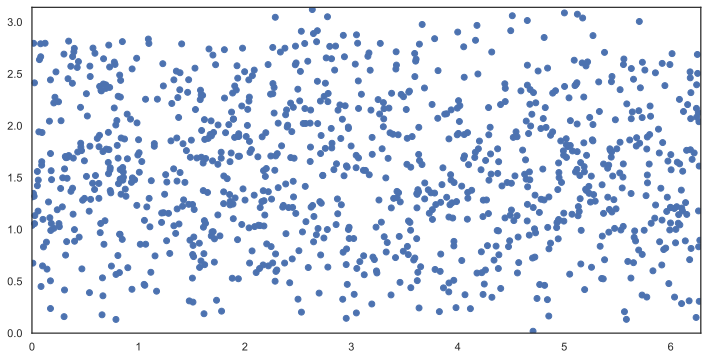

In [18]:
plt.scatter(latlons[0:1000,1], latlons[0:1000,0])
# plt.xlim(0, 360)
plt.xlim(0, 2*math.pi)
plt.ylim(0, math.pi)
# plt.ylim(-90, 90)
plt.show()

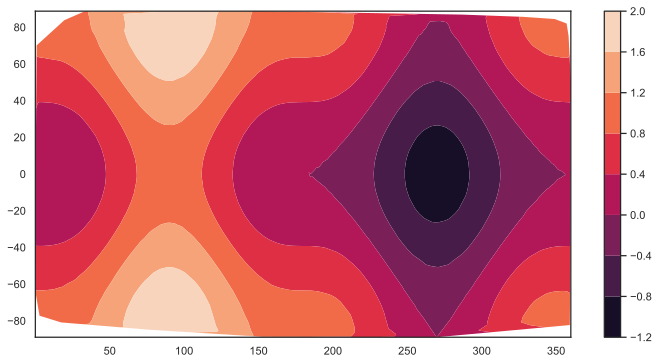

In [19]:
plt.tricontourf(np.rad2deg(latlons[:,1]), np.rad2deg(latlons[:,0] - math.pi / 2), values)
plt.colorbar()
plt.show()

In [20]:
icos_mesh.assign_points_cart(points)

In [21]:
icos_mesh.assign_values(values)

In [22]:
icos_mesh.assign_areas(areas)

In [23]:
def test_function(p1, p2):
#     print(np.dot(p1, p2))
#     return 1
    val = np.dot(p1, p2)
    if np.abs(val - 1) < 1e-6:
        return 0
    else:
        return np.linalg.norm(np.cross(p1, p2) / (1 - val))
#     val = gcdist(p1, p2, 1)
#     return val
#     return np.linalg.norm(p1 - p2)
#     if val < 1e-10:
#         return 0
#     else:
#         return val
#     return gcdist(p1, p2, 1)

In [29]:
direct_conv = icos_mesh.convolve_direct(test_function)

257.1181182861328


In [24]:
lev0_conv0810, t0810 = icos_mesh.convolve_approx(test_function, 0.8, 10)

In [25]:
lev0_conv0809, t0809 = icos_mesh.convolve_approx(test_function, 0.8, 9)

In [26]:
lev0_conv0808, t0808 = icos_mesh.convolve_approx(test_function, 0.8, 8)

In [27]:
lev0_conv0807, t0807 = icos_mesh.convolve_approx(test_function, 0.8, 7)

In [28]:
lev0_conv0806, t0806 = icos_mesh.convolve_approx(test_function, 0.8, 6)

In [35]:
lev0_conv06, t0610 = icos_mesh.convolve_approx(test_function, 0.6, 10)

In [31]:
lev0_conv07, t0710 = icos_mesh.convolve_approx(test_function, 0.7, 10)

In [32]:
lev0_conv05, t0510 = icos_mesh.convolve_approx(test_function, 0.5, 10)

In [33]:
lev0_conv09, t0910 = icos_mesh.convolve_approx(test_function, 0.9, 10)

In [34]:
lev0_conv10, t1010 = icos_mesh.convolve_approx(test_function, 1.0, 10)

In [36]:
np.linalg.norm(lev0_conv0810-direct_conv) / np.linalg.norm(direct_conv)
# 4.1% error on method 2, 6 points
# 11% error with tree code, theta=0.8, 50 seconds
# 6% error, theta=0.6, 80 seconds

0.11656621651118891

In [37]:
t0806

53.73221516609192

In [22]:
errors1 = np.zeros(5)
errors2 = np.zeros(6)

In [23]:
errors1[0] = np.linalg.norm(lev0_conv0806-direct_conv) / np.linalg.norm(direct_conv)
errors1[1] = np.linalg.norm(lev0_conv0807-direct_conv) / np.linalg.norm(direct_conv)
errors1[2] = np.linalg.norm(lev0_conv0808-direct_conv) / np.linalg.norm(direct_conv)
errors1[3] = np.linalg.norm(lev0_conv0809-direct_conv) / np.linalg.norm(direct_conv)
errors1[4] = np.linalg.norm(lev0_conv0810-direct_conv) / np.linalg.norm(direct_conv)

NameError: name 'lev0_conv0806' is not defined

In [24]:
errors2[0] = np.linalg.norm(lev0_conv05-direct_conv) / np.linalg.norm(direct_conv)
errors2[1] = np.linalg.norm(lev0_conv06-direct_conv) / np.linalg.norm(direct_conv)
errors2[2] = np.linalg.norm(lev0_conv07-direct_conv) / np.linalg.norm(direct_conv)
errors2[3] = np.linalg.norm(lev0_conv0810-direct_conv) / np.linalg.norm(direct_conv)
errors2[4] = np.linalg.norm(lev0_conv09-direct_conv) / np.linalg.norm(direct_conv)
errors2[5] = np.linalg.norm(lev0_conv10-direct_conv) / np.linalg.norm(direct_conv)

NameError: name 'lev0_conv05' is not defined

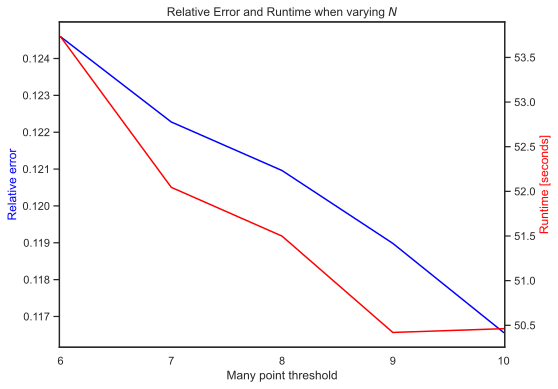

In [65]:
fig, ax = plt.subplots()
ax.plot([6, 7, 8, 9, 10], errors1, label='Relative Error', color='blue')
ax.set_xlabel('Many point threshold')
ax.set_ylabel('Relative error', color='blue')
ax.set_xlim(5.99, 10.01)
ax.set_xticks([6, 7, 8, 9, 10])
ax.set_title('Relative Error and Runtime when varying $N$')
ax2=ax.twinx()
ax2.plot([6, 7, 8, 9, 10], [t0806, t0807, t0808, t0809, t0810], color='red')
ax2.set_ylabel('Runtime [seconds]', color='red')
plt.show()

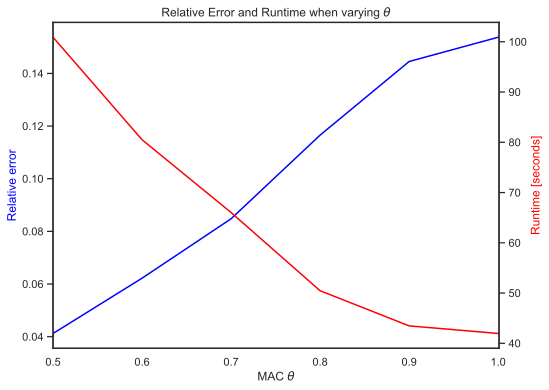

In [71]:
fig, ax = plt.subplots()
ax.plot([0.5, 0.6, 0.7, 0.8, 0.9, 1.0], errors2, label='Relative Error', color='blue')
ax.set_xlabel(r'MAC $\theta$')
ax.set_ylabel('Relative error', color='blue')
ax.set_xlim(0.599, 1.001)
ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_title(r'Relative Error and Runtime when varying $\theta$')
ax2=ax.twinx()
ax2.plot([0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [t0510, t0610, t0710, t0810, t0910, t1010], color='red')
ax2.set_ylabel('Runtime [seconds]', color='red')
plt.show()

In [20]:
icos_mesh.triangles[0][0]

array([0.        , 1.        , 8.        , 0.35682209, 0.        ,
       0.93417236, 0.62831853, 0.69256163])